In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pyproj
import numpy as np
import pandas as pd
import xarray as xr
import verde as vd
from vectorspline3d import VectorSpline3D
from vectorspline3d.utils import sample_from_grid

In [2]:
grid = xr.open_dataset("../../data/xvel_2017.grd")
grid["north_velocity"] = xr.open_dataarray('../../data/yvel_2017.grd')
grid["up_velocity"] = xr.open_dataarray('../../data/zvel_2017.grd')
grid = grid.rename(dict(z="east_velocity", x="easting", y="northing"))
grid = grid.sel(easting=slice(300, 750, 5), northing=slice(100, 1000, 5))
grid.to_netcdf("../../data/synthetic-san-andreas-2017.nc", )
grid

<xarray.Dataset>
Dimensions:         (easting: 180, northing: 360)
Coordinates:
  * easting         (easting) float64 300.2 302.8 305.2 ... 742.8 745.2 747.8
  * northing        (northing) float64 100.2 102.8 105.2 ... 992.8 995.2 997.8
Data variables:
    east_velocity   (northing, easting) float32 ...
    north_velocity  (northing, easting) float32 ...
    up_velocity     (northing, easting) float32 ...
Attributes:
    Conventions:  COARDS, CF-1.5
    title:        Produced by grdcut
    history:      grdcut xvel_2017.grd -Gxvel_2017c.grd -R0/1000/0/1700
    description:  
    GMT_version:  5.4.2 (r18461) [64-bit]
    node_offset:  1

## Load the 3-component synthetic grid

In [3]:
grid = xr.open_dataset("../../data/synthetic-san-andreas-2017.nc")
grid

<xarray.Dataset>
Dimensions:         (easting: 180, northing: 360)
Coordinates:
  * easting         (easting) float64 300.2 302.8 305.2 ... 742.8 745.2 747.8
  * northing        (northing) float64 100.2 102.8 105.2 ... 992.8 995.2 997.8
Data variables:
    east_velocity   (northing, easting) float32 ...
    north_velocity  (northing, easting) float32 ...
    up_velocity     (northing, easting) float32 ...
Attributes:
    Conventions:  COARDS, CF-1.5
    title:        Produced by grdcut
    history:      grdcut xvel_2017.grd -Gxvel_2017c.grd -R0/1000/0/1700
    description:  
    GMT_version:  5.4.2 (r18461) [64-bit]
    node_offset:  1

Extract some useful values from the grid, like grid spacing, region, and coordinates.

In [4]:
region = vd.get_region((grid.easting, grid.northing))
spacing = (grid.easting.values[1] - grid.easting.values[0], grid.northing.values[1] - grid.northing.values[0])
grid_coords = np.meshgrid(grid.easting, grid.northing)
grid_components = (grid.east_velocity.values, grid.north_velocity.values, grid.up_velocity.values)
print(spacing)

(2.5, 2.5)


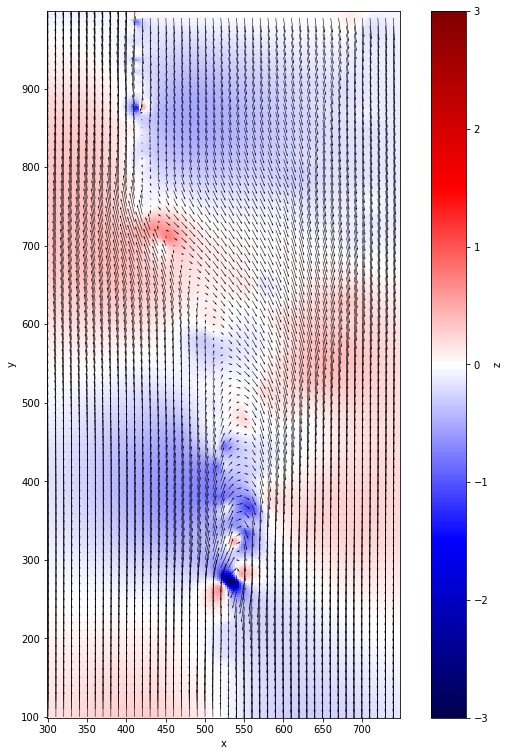

In [5]:
maxabs = 3
every = 4
qscale = 250
qwidth = 0.0015
figsize = (11, 13)
plt.figure(figsize=figsize)
ax = plt.subplot(111)
grid.up_velocity.plot.pcolormesh(vmin=-maxabs, vmax=maxabs, cmap="seismic")
down = grid.isel(easting=slice(None, None, every), northing=slice(None, None, every))
ax.quiver(down.easting, down.northing, down.east_velocity, down.north_velocity, scale=qscale, width=qwidth)
ax.set_aspect("equal")
#ax.grid()

## Extract random samples

In [14]:
ndata = 3000
data = sample_from_grid(grid, size=1200, random_state=10)
data = pd.concat([
    data, 
    sample_from_grid(grid.sel(easting=slice(480, 600), northing=slice(None, 600)), 
                     size=ndata - data.shape[0], random_state=0)
])
coordinates = (data.easting, data.northing)
components = (data.east_velocity, data.north_velocity, data.up_velocity)
data.head()

,east_velocity,north_velocity,up_velocity,easting,northing
0,0.157104,17.559160,-0.086046,322.75,295.25
1,0.503299,-18.589558,0.082277,612.75,405.25
2,-1.709417,19.121187,0.368348,337.75,770.25
3,1.490131,16.245285,-0.610263,460.25,357.75
4,3.669240,-8.317380,-0.154250,582.75,765.25


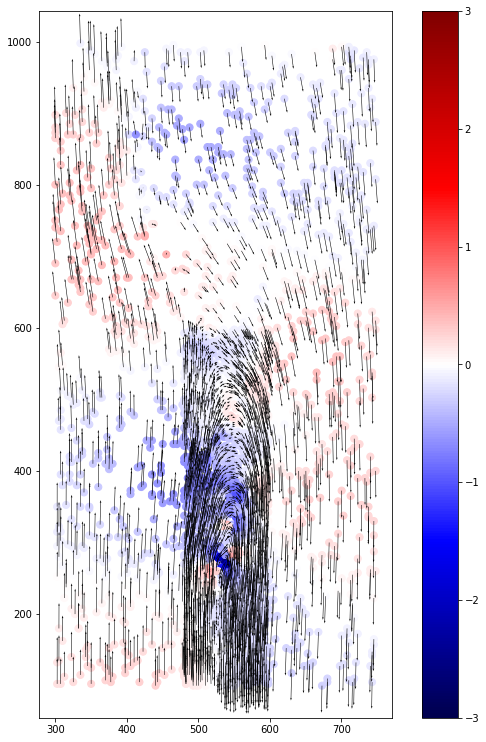

In [15]:
plt.figure(figsize=figsize)
ax = plt.subplot(111)
tmp = ax.scatter(data.easting, data.northing, s=50, c=data.up_velocity,
                 vmin=-maxabs, vmax=maxabs, cmap="seismic")
plt.colorbar(tmp, ax=ax)
ax.quiver(data.easting, data.northing, data.east_velocity, data.north_velocity, scale=qscale, width=qwidth)
ax.set_aspect("equal")

In [16]:
(np.linalg.norm(data.up_velocity, ord=1)**2/np.linalg.norm(data.east_velocity, ord=1)**2)

0.02026224390807727

In [17]:
%%time
n = np.floor(np.sqrt(ndata))
force_coords = vd.grid_coordinates(vd.pad_region(region, 100), shape=(n, n))
force_coords = vd.BlockReduce(reduction=np.mean, spacing=spacing).filter(coordinates, np.ones(ndata))[0]
weights = (np.full(ndata, 0.0001), np.full(ndata, 0.0001), np.full(ndata, 1.0))
spline = VectorSpline3D(poisson=0.5, depth=30, damping=1e-2, force_coords=force_coords)
spline.fit(coordinates, components, weights=weights)

CPU times: user 35.7 s, sys: 4.45 s, total: 40.1 s
Wall time: 6.79 s


In [18]:
%%time
print("Score on sampled data:", spline.score(coordinates, components))
print("Score on grid data:", spline.score(grid_coords, grid_components))

Score on sampled data: 0.9878746613113454
Score on grid data: 0.9688065634525431
CPU times: user 5.05 s, sys: 21.1 ms, total: 5.07 s
Wall time: 674 ms


In [19]:
grid_spl = spline.grid(spacing=spacing, data_names=["east_velocity", 'north_velocity', "up_velocity"])

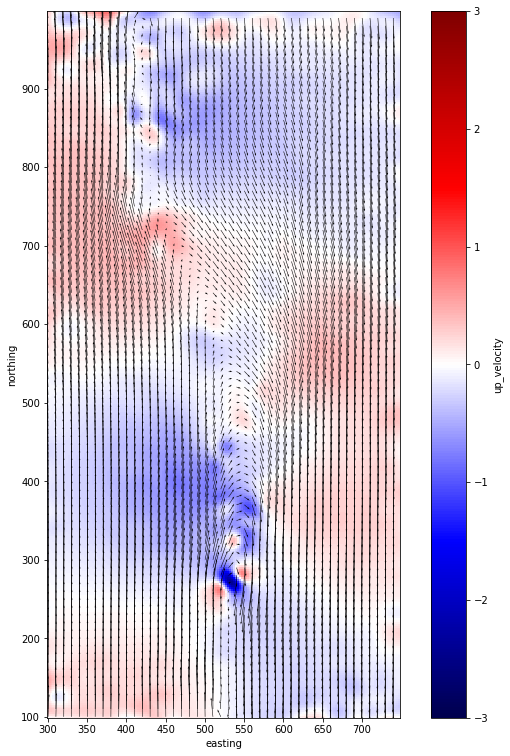

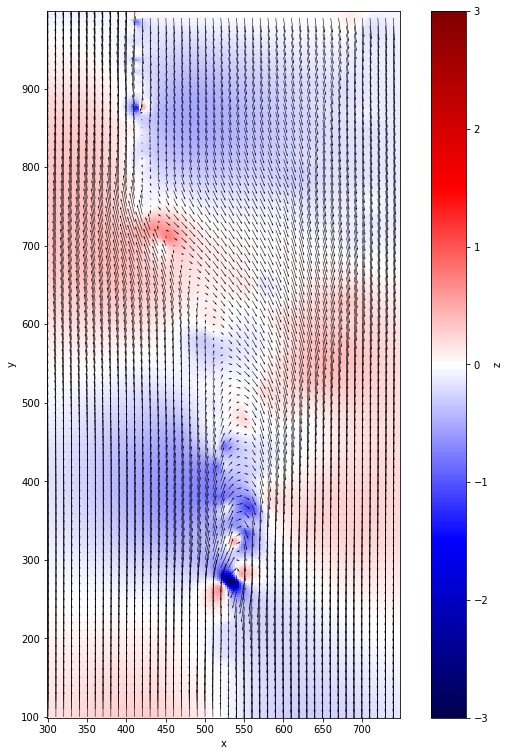

In [20]:
plt.figure(figsize=figsize)
ax = plt.subplot(111)
grid_spl.up_velocity.plot.pcolormesh(vmin=-maxabs, vmax=maxabs, cmap="seismic")
down = grid_spl.isel(easting=slice(None, None, every), 
                     northing=slice(None, None, every))
ax.quiver(down.easting, down.northing, down.east_velocity, down.north_velocity, scale=qscale, width=qwidth)
ax.set_aspect("equal")
plt.figure(figsize=figsize)
ax = plt.subplot(111)
grid.up_velocity.plot.pcolormesh(vmin=-maxabs, vmax=maxabs, cmap="seismic")
down = grid.isel(easting=slice(None, None, every), 
                 northing=slice(None, None, every))
ax.quiver(down.easting, down.northing, down.east_velocity, down.north_velocity, scale=qscale, width=qwidth)
ax.set_aspect("equal")

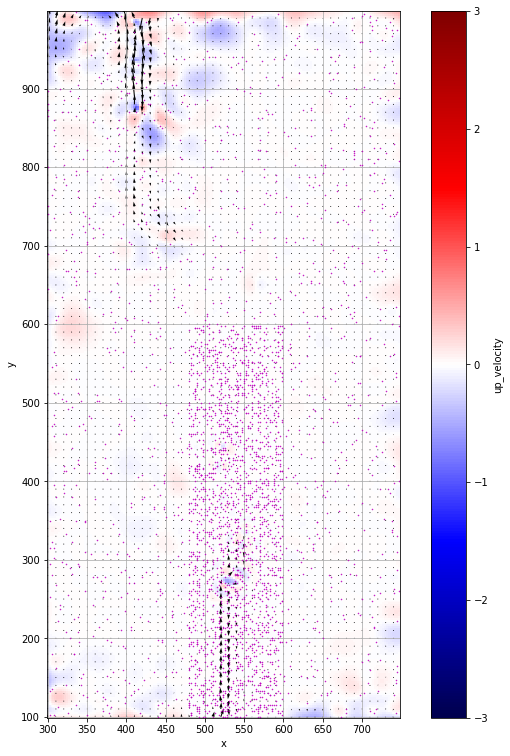

In [21]:
plt.figure(figsize=figsize)
ax = plt.subplot(111)
diff = grid - grid_spl
diff.up_velocity.plot.pcolormesh(vmin=-maxabs, vmax=maxabs, cmap="seismic")
ax.plot(data.easting, data.northing, "m.", markersize=1)
down = diff.isel(easting=slice(None, None, every), northing=slice(None, None, every))
ax.quiver(down.easting, down.northing, down.east_velocity, down.north_velocity, scale=qscale, width=qwidth*2)
ax.set_aspect("equal")
ax.grid()